LST Withdrawal analysis:
1. There are n buckets that can stake STRK with starknet from our end. 
2. ⁠Each bucket can have one active withdrawal request. it takes 21 days to fulfil one request. In this case, if a bucket requests withdrawal again, it will reset old one and timer also will reset to 21 days from the new request made. 

Points to note:
- We do not exactly know how much deposits we will get in future at present. Each day we have to decide which bucket we will use to deposit the incoming amount. We can choose to deposit in 1 or more buckets. 
- ⁠⁠Similarly, we do not know future withdrawals, we only know past. 
- ⁠We could also use some of deposits of the day as well to process withdrawals may be and then handle the excess or deficit at the end of day.

However, feel free to analyse historical deposit/withdrawal data analysis of other staking projects (e.g. lido on ethereum). 

Optimise for minimal wait time (i.e. Most of the times, the withdrawal wait time has to be as low as possible) 

Expected insights:
1. How many buckets should we maintain?
2. ⁠How to choose bucket(s) to use to add new deposits of the day?
3. ⁠How to choose buckets to process withdrawals

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
from scipy.stats import norm

# net inflow positive unte stake 
# negative unstake

In [48]:

def simulate_withdrawal(total_tokens, no_buckets, token_distribution, withdrawals):
    """
    Simulates the withdrawal process by distributing the specified withdrawal amount across multiple buckets.

    Args:
        total_tokens (float): The total number of tokens available for withdrawal.
        no_buckets (int): The number of buckets used for withdrawal.
        token_distribution (list of float): An array representing the percentage share for each bucket.
        withdrawals (list of float): An array representing past withdrawal requests. Each element represents the pooled amount requested in a day.

    Returns:
        dict: Contains:
            - "waiting_period" (list of float): Number of days each withdrawer needs to wait.
            - "buckets_status" (list of dict): Status of each bucket showing if it's active, the remaining capacity, and the remaining days for any active request.
    """
 
    # Initialize bucket statuses
    buckets_status = [{"tokens_initial": token_distribution[bucket_id],"tokens_available": token_distribution[bucket_id], "tokens_wait": 0, "current_wait_time": 0, "state": "unstaked", "withdrawn_id": []} for bucket_id in range(no_buckets)]
    # Initialize withdrawal status
    withdrawal_status = [{"amount": withdrawals[withdrawal_id], "start_time":withdrawal_id, "end_time":0, "pending_unstakes": withdrawals[withdrawal_id], "wait_time": 0, "withdrawn_id_timespent": 0, "remaining": withdrawals[withdrawal_id]} for withdrawal_id in range(len(withdrawals))]
    total_token_unstaked = 0 
    token_unstaked_today = 0
    # Process each day's withdrawal
    for withdrawal_id in range(len(withdrawals)):
        # Continue processing until the withdrawal is fully allocated
        while withdrawal_status[withdrawal_id]["remaining"] > 0:
            # Exact match for unstaked buckets
            for bucket_id in range(no_buckets):
                if buckets_status[bucket_id]["tokens_available"] == withdrawal_status[withdrawal_id]["remaining"] and buckets_status[bucket_id]["state"] == "unstaked":
                    buckets_status[bucket_id]["tokens_available"] = 0
                    buckets_status[bucket_id]["current_wait_time"] = 21
                    buckets_status[bucket_id]["tokens_wait"] += buckets_status[bucket_id]["tokens_available"]
                    buckets_status[bucket_id]["withdrawn_id"].append(withdrawal_id)
                    total_token_unstaked += withdrawal_status[withdrawal_id]["remaining"]
                    withdrawal_status[withdrawal_id]["remaining"] = 0
                    for withdrawn_id in buckets_status[bucket_id]["withdrawn_id"]:
                        withdrawal_status[withdrawn_id]["wait_time"] = 21 + withdrawal_status[withdrawn_id]["withdrawn_id_timespent"] 
                        withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]  = 0
                    break

            # Full allocation for unstaked buckets
            for bucket_id in range(no_buckets):
                if withdrawal_status[withdrawal_id]["remaining"] == 0:
                    break
                if buckets_status[bucket_id]["tokens_available"] > withdrawal_status[withdrawal_id]["remaining"] and buckets_status[bucket_id]["state"] == "unstaked":
                    buckets_status[bucket_id]["tokens_available"] -= withdrawal_status[withdrawal_id]["remaining"]
                    buckets_status[bucket_id]["current_wait_time"] = 21
                    buckets_status[bucket_id]["tokens_wait"] += withdrawal_status[withdrawal_id]["remaining"]
                    buckets_status[bucket_id]["withdrawn_id"].append(withdrawal_id)
                    total_token_unstaked += withdrawal_status[withdrawal_id]["remaining"]
                    withdrawal_status[withdrawal_id]["remaining"] = 0
                    for withdrawn_id in buckets_status[bucket_id]["withdrawn_id"]:
                        withdrawal_status[withdrawn_id]["wait_time"] = 21 + withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]                   
                        withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]  = 0
                    break

            # Partial allocation for unstaked buckets
            for bucket_id in range(no_buckets):
                if withdrawal_status[withdrawal_id]["remaining"] == 0:
                    break
                if 0 < buckets_status[bucket_id]["tokens_available"] < withdrawal_status[withdrawal_id]["remaining"] and buckets_status[bucket_id]["state"] == "unstaked":
                    allocated = min(buckets_status[bucket_id]["tokens_available"], withdrawal_status[withdrawal_id]["remaining"])
                    total_token_unstaked += allocated
                    token_unstaked_today += allocated
                    withdrawal_status[withdrawal_id]["remaining"] -= allocated
                    buckets_status[bucket_id]["tokens_available"] -= allocated
                    buckets_status[bucket_id]["current_wait_time"] = 21
                    buckets_status[bucket_id]["tokens_wait"] += allocated
                    buckets_status[bucket_id]["withdrawn_id"].append(withdrawal_id)
                    for withdrawn_id in buckets_status[bucket_id]["withdrawn_id"]:
                        withdrawal_status[withdrawn_id]["wait_time"] = 21 + withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]                   
                        withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]  = 0

            # If the withdrawal is still not fully allocated, proceed with staked buckets

            # Exact match for staked buckets
            for bucket_id in range(no_buckets):
                if withdrawal_status[withdrawal_id]["remaining"] == 0:
                    break
                if buckets_status[bucket_id]["tokens_available"] == withdrawal_status[withdrawal_id]["remaining"] and buckets_status[bucket_id]["state"] == "staked":
                    buckets_status[bucket_id]["tokens_available"] = 0
                    buckets_status[bucket_id]["current_wait_time"] = 21
                    buckets_status[bucket_id]["tokens_wait"] += buckets_status[bucket_id]["tokens_available"]
                    buckets_status[bucket_id]["withdrawn_id"].append(withdrawal_id)
                    total_token_unstaked += withdrawal_status[withdrawal_id]["remaining"]
                    token_unstaked_today += withdrawal_status[withdrawal_id]["remaining"]
                    withdrawal_status[withdrawal_id]["remaining"] = 0
                    for withdrawn_id in buckets_status[bucket_id]["withdrawn_id"]:
                        withdrawal_status[withdrawn_id]["wait_time"] = 21 + withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]                   
                        withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]  = 0
                    break

            # Full allocation for staked buckets
            for bucket_id in range(no_buckets):
                if withdrawal_status[withdrawal_id]["remaining"] == 0:
                    break
                if buckets_status[bucket_id]["tokens_available"] > withdrawal_status[withdrawal_id]["remaining"] and buckets_status[bucket_id]["state"] == "staked":
                    buckets_status[bucket_id]["tokens_available"] -= withdrawal_status[withdrawal_id]["remaining"]
                    buckets_status[bucket_id]["current_wait_time"] = 21
                    buckets_status[bucket_id]["tokens_wait"] += withdrawal_status[withdrawal_id]["remaining"]
                    buckets_status[bucket_id]["withdrawn_id"].append(withdrawal_id)
                    total_token_unstaked += withdrawal_status[withdrawal_id]["remaining"]
                    token_unstaked_today += withdrawal_status[withdrawal_id]["remaining"]
                    withdrawal_status[withdrawal_id]["remaining"] = 0
                    for withdrawn_id in buckets_status[bucket_id]["withdrawn_id"]:
                        withdrawal_status[withdrawn_id]["wait_time"] = 21 + withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]                   
                        withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]  = 0
                    break

            # Partial allocation for staked buckets
            for bucket_id in range(no_buckets):
                if withdrawal_status[withdrawal_id]["remaining"] == 0:
                    break
                if 0 < buckets_status[bucket_id]["tokens_available"] < withdrawal_status[withdrawal_id]["remaining"] and buckets_status[bucket_id]["state"] == "staked":
                    allocated = min(buckets_status[bucket_id]["tokens_available"], withdrawal_status[withdrawal_id]["remaining"])
                    total_token_unstaked += allocated
                    token_unstaked_today += allocated
                    withdrawal_status[withdrawal_id]["remaining"] -= allocated
                    buckets_status[bucket_id]["tokens_available"] -= allocated
                    buckets_status[bucket_id]["current_wait_time"] = 21
                    buckets_status[bucket_id]["tokens_wait"] += allocated
                    buckets_status[bucket_id]["withdrawn_id"].append(withdrawal_id)
                    for withdrawn_id in buckets_status[bucket_id]["withdrawn_id"]:
                        withdrawal_status[withdrawn_id]["wait_time"] = 21 + withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]                   
                        withdrawal_status[withdrawn_id]["withdrawn_id_timespent"]  = 0
            
            # Check if the sum of tokens available across all buckets is zero
            total_tokens_available = sum(bucket["tokens_available"] for bucket in buckets_status)
            if total_tokens_available == 0:
                print("All buckets are fully utilized. Stopping further withdrawals.")
                break
                
                
        # Adjust wait times at the end of each iteration (simulating day end)
        for bucket in buckets_status:
            if bucket["current_wait_time"] > 0:
                bucket["current_wait_time"] -= 1
                bucket["state"] = "staked"
            elif bucket["current_wait_time"] == 0:
                bucket["state"] = "unstaked"
                bucket["withdrawn_id"] = []
                for wid in range(withdrawal_id+1):  
                    while bucket["tokens_wait"] > 0 and withdrawal_status[wid]["pending_unstakes"] > 0:
                        settled = min(withdrawal_status[wid]["pending_unstakes"], bucket["tokens_wait"])
                        withdrawal_status[wid]["pending_unstakes"] -= settled
                        bucket["tokens_wait"] -= settled
                        if settled > 0:
                            withdrawal_status[wid]["end_time"] = withdrawal_id
                
        for wid in range(withdrawal_id+1):
            withdrawal_status[wid]["withdrawn_id_timespent"] += 1
            if withdrawal_status[wid]["withdrawn_id_timespent"] == 21:
                withdrawal_status[wid]["withdrawn_id_timespent"] = 0
        
#         if (withdrawal_id%10) == 0:
#             print(withdrawal_id)
         
    return {
        "buckets_status": buckets_status,
        "withdrawal_status": withdrawal_status,
        "mean_wait_time": statistics.mean([withdrawal["wait_time"] for withdrawal in withdrawal_status]),
        "increment_waittime": sum(withdrawal["wait_time"] for withdrawal in withdrawal_status) - 21*len(withdrawals),
        "tokens_unstaked": total_token_unstaked
    }


In [49]:
def simulate_withdrawal_result(no_buckets):
    # Simulation constants
    amount_available = 90000  # Total available tokens (STRK)
    mean_bucket = 0.3  # Mean allocation per bucket (normalized)
    sd_bucket = 0.1  # Standard deviation for allocation per bucket
    no_withdrawals = 100  # Number of withdrawal requests
    mean_unstake = 0.5  # Mean unstake percentage
    sd_unstake = 0.5  # Standard deviation for unstake percentage

    # Generate token distribution across buckets
    distribution = np.clip(np.random.normal(mean_bucket, sd_bucket, no_buckets), 0, 1)
    distribution /= distribution.sum()  # Normalize to ensure the sum equals 1
    token_distribution = sorted([percent * amount_available for percent in distribution])

    # Generate withdrawals with all positive values by taking absolute value
    mean_value = mean_unstake / 100 * amount_available
    sd_value = sd_unstake / 100 * amount_available
    withdrawals = np.abs(np.random.normal(mean_value, sd_value, no_withdrawals))

    # Run the withdrawal simulation (assuming simulate_withdrawal is a predefined function)
    simulation_result = simulate_withdrawal(amount_available, no_buckets, token_distribution, withdrawals)

    # Calculate mean wait time
    df_withdrawals = pd.DataFrame(simulation_result["withdrawal_status"])
    df_withdrawals["diff_time"] = df_withdrawals["end_time"] - df_withdrawals["start_time"]
    mean_positive_diff_time = df_withdrawals[df_withdrawals["diff_time"] > 0]["diff_time"].mean()

    df_buckets = pd.DataFrame(simulation_result["buckets_status"])
    
    return simulation_result, mean_positive_diff_time, df_withdrawals, df_buckets, token_distribution, withdrawals





In [50]:
no_buckets = 21
simulation_result, mean_wait_time, df_withdrawals, df_buckets, token_distribution, withdrawals = simulate_withdrawal_result(no_buckets)
print("Mean Wait Time actual:", mean_wait_time)
print("Mean wait time according to buckets:", simulation_result["mean_wait_time"])
display("df_withdrawals:", df_withdrawals)
display("df_buckets:", df_buckets)


Mean Wait Time actual: 25.51388888888889
Mean wait time according to buckets: 22.38


'df_withdrawals:'

,amount,start_time,end_time,pending_unstakes,wait_time,withdrawn_id_timespent,remaining,diff_time
0,927.040747,0,21,0.000000,21,16,0,21
1,197.257861,1,24,0.000000,41,16,0,23
2,245.535427,2,24,0.000000,22,13,0,22
3,1264.240427,3,27,0.000000,21,13,0,24
4,410.114964,4,29,0.000000,21,12,0,25
...,...,...,...,...,...,...,...,...
95,649.440655,95,0,649.440655,24,2,0,-95
96,917.788055,96,0,917.788055,21,4,0,-96
97,17.730833,97,0,17.730833,21,3,0,-97
98,329.600466,98,0,329.600466,21,2,0,-98


'df_buckets:'

,tokens_initial,tokens_available,tokens_wait,current_wait_time,state,withdrawn_id
0,2129.603544,0.000000,0.000000,0,unstaked,[]
1,2271.738593,0.000000,0.000000,0,unstaked,[]
2,2950.797105,0.000000,0.000000,0,unstaked,[]
3,2962.639118,0.000000,0.000000,0,unstaked,[]
4,3205.640153,0.000000,34.953912,13,staked,[92]
5,3461.532347,0.000000,34.697722,15,staked,[94]
6,3628.244390,23.923022,2854.103223,18,staked,"[50, 68, 71, 89, 92, 97]"
7,3704.815306,171.864979,2090.480125,15,staked,"[73, 87, 94]"
8,3759.131623,42.262522,1557.539899,9,staked,"[74, 88]"
9,3784.118218,35.843370,3050.077733,19,staked,"[75, 90, 91, 93, 95, 98]"


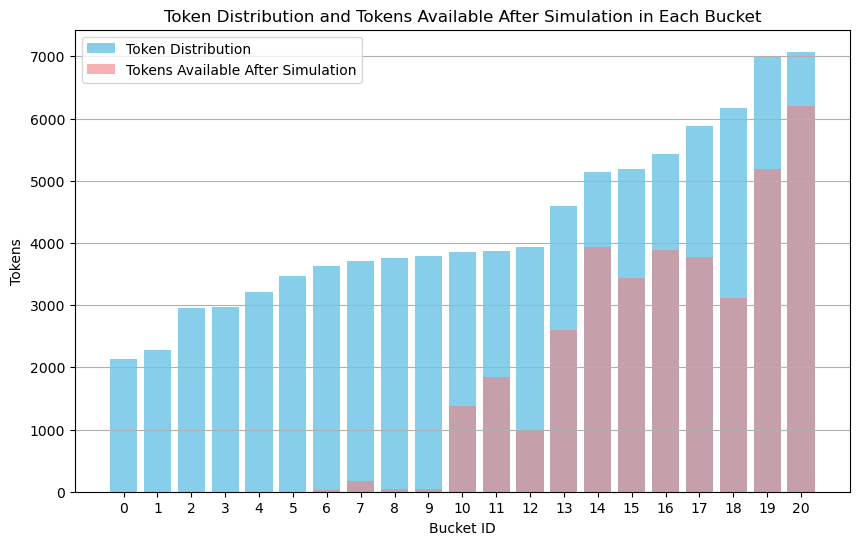

In [51]:
# Assuming `simulation_result` is the output from the `simulate_withdrawal` function
tokens_available = [bucket["tokens_available"] for bucket in simulation_result["buckets_status"]]

# Create a bar plot for token distribution (base layer)
plt.figure(figsize=(10, 6))
plt.bar(range(len(token_distribution)), token_distribution, color='skyblue', label="Token Distribution")

# Overlay the tokens available in each bucket (lighter color inside)
plt.bar(range(len(tokens_available)), tokens_available, color='lightcoral', alpha=0.6, label="Tokens Available After Simulation")

# Labels and title
plt.xlabel("Bucket ID")
plt.ylabel("Tokens")
plt.title("Token Distribution and Tokens Available After Simulation in Each Bucket")
plt.xticks(range(len(token_distribution)))  # Set x-ticks to bucket IDs
plt.legend()
plt.grid(axis='y')
plt.show()


Text(0.5, 1.0, 'Withdrawal Amounts')

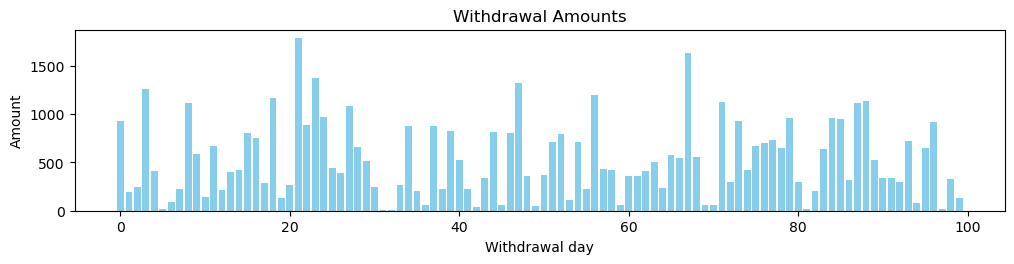

In [52]:
# Assuming `withdrawal_status` is a list of dictionaries with keys "amount", "wait_time", and "remaining"
withdrawal_amounts = [withdrawal["amount"] for withdrawal in simulation_result["withdrawal_status"]]
wait_times = [withdrawal["wait_time"] for withdrawal in simulation_result["withdrawal_status"]]
remaining_amounts = [withdrawal["remaining"] for withdrawal in simulation_result["withdrawal_status"]]

# Plot each attribute in a separate subplot
plt.figure(figsize=(12, 8))

# Plot 1: Withdrawal Amounts
plt.subplot(3, 1, 1)
plt.bar(range(len(withdrawal_amounts)), withdrawal_amounts, color='skyblue')
plt.xlabel("Withdrawal day")
plt.ylabel("Amount")
plt.title("Withdrawal Amounts")


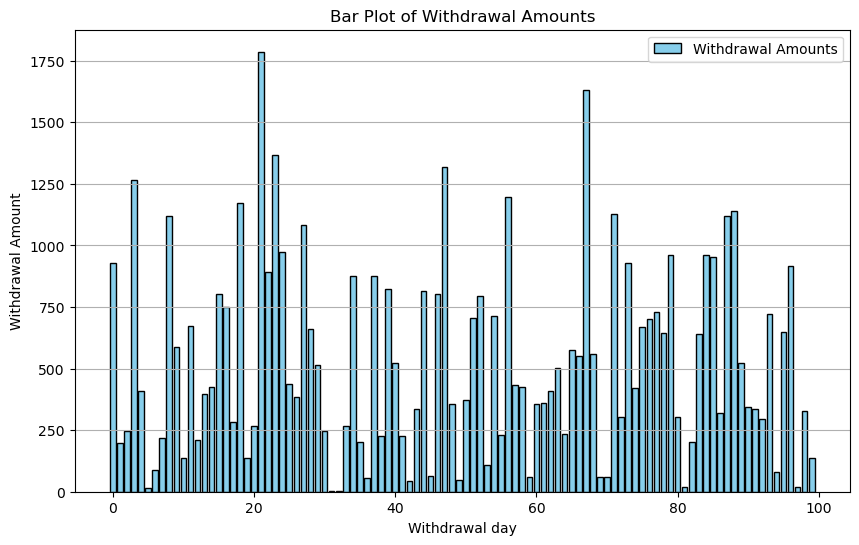

In [53]:
# Assuming `withdrawal_amounts` is a list of withdrawal amounts
withdrawal_amounts = [withdrawal["amount"] for withdrawal in simulation_result["withdrawal_status"]]

# Generate indices for each withdrawal
withdrawal_indices = range(len(withdrawal_amounts))

# Plot the bar plot of withdrawal amounts
plt.figure(figsize=(10, 6))
plt.bar(withdrawal_indices, withdrawal_amounts, color='skyblue', edgecolor='black', label="Withdrawal Amounts")

# Labels and title
plt.xlabel("Withdrawal day")
plt.ylabel("Withdrawal Amount")
plt.title("Bar Plot of Withdrawal Amounts")
plt.legend()
plt.grid(axis='y')
plt.show()


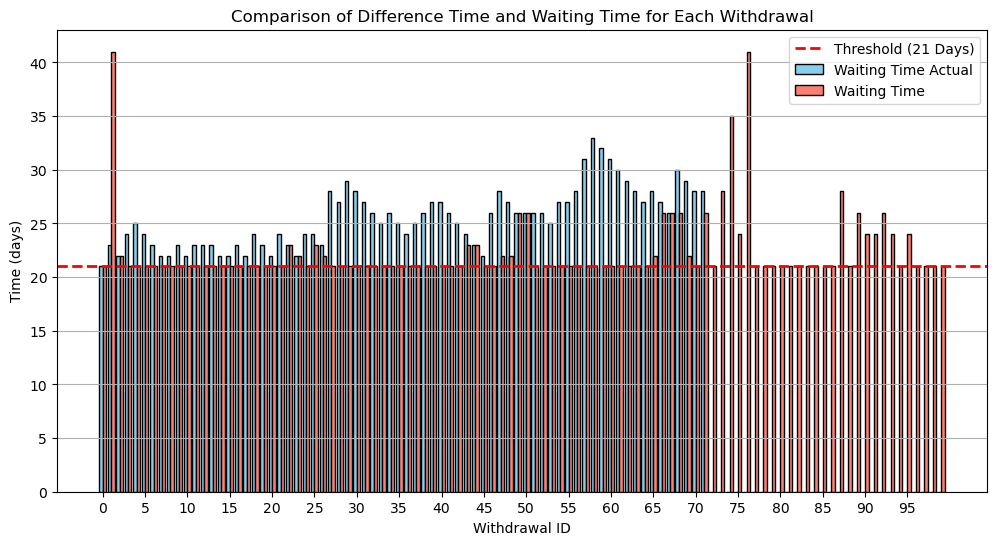

In [54]:
# Set negative values in 'diff_time' to 0
df_withdrawals["diff_time"] = df_withdrawals["diff_time"].apply(lambda x: x if x > 0 else 0)

# Plot the diff_time and wait_time as side-by-side bar plots
plt.figure(figsize=(12, 6))
width = 0.4  # Width of the bars

# Positions for the diff_time and wait_time bars
indices = np.arange(len(df_withdrawals))
plt.bar(indices - width/2, df_withdrawals["diff_time"], width=width, color='skyblue', edgecolor='black', label="Waiting Time Actual")
plt.bar(indices + width/2, df_withdrawals["wait_time"], width=width, color='salmon', edgecolor='black', label="Waiting Time")

# Add a horizontal line at 21 days
plt.axhline(y=21, color='red', linestyle='--', linewidth=2, label="Threshold (21 Days)")

# Labels and title
plt.xlabel("Withdrawal ID")
plt.ylabel("Time (days)")
plt.title("Comparison of Difference Time and Waiting Time for Each Withdrawal")

# Set x-ticks to display every 5th withdrawal ID
plt.xticks(indices[::5])  # Display every 5th tick

# Show legend with updated names
plt.legend()
plt.grid(axis='y')
plt.show()


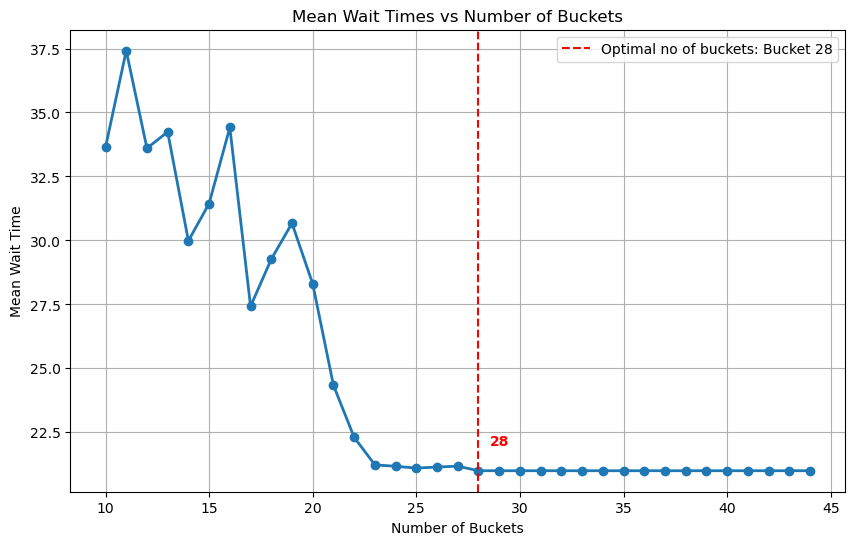

In [71]:
l = 10
u = 45

wait_times_array = []
for no_buckets in range(l,u):
    simulation_result, mean_wait_time, df_withdrawals, df_buckets, token_distribution, withdrawals = simulate_withdrawal_result(no_buckets)
    wait_times_array.append(mean_wait_time)


# Define a target wait time value (y-value) to locate in the array
target_wait_time = 21

# Find the x value (bucket number) closest to the target y value
closest_index = np.argmin([abs(wait_time - target_wait_time) for wait_time in wait_times_array])
closest_bucket = l + closest_index  # Calculate bucket number based on index

# Display the results
closest_wait_time = wait_times_array[closest_index]
closest_bucket, closest_wait_time


# Plot mean wait times
plt.figure(figsize=(10, 6))
plt.plot(range(l, u), wait_times_array, marker='o', linestyle='-', linewidth=2)
plt.title("Mean Wait Times vs Number of Buckets")
plt.xlabel("Number of Buckets")
plt.ylabel("Mean Wait Time")
plt.grid(True)

# Add vertical line at the 21st bucket and annotate it
plt.axvline(x=closest_bucket, color='r', linestyle='--', label=f'Optimal no of buckets: Bucket {closest_bucket}')
plt.text(closest_bucket+1, wait_times_array[closest_bucket] + 1, f'{closest_bucket}', 
         ha='center', color='red', fontweight='bold')

# Show plot with legend
plt.legend()
plt.show()
